# kaggle project
AIFFEL 대전 탐색 노드 9    
Kaggle project이다.   
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/overview   
  
프로세스는 다음과 같다.     
1. Import package 
2. EDA
3. Data preprocessing
4. Modeling
5. Analysis

## 1. Import package

In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

## 2. EDA

### 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/home/aiffel-dj28/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj28/aiffel/kaggle_kakr_housing/data/test.csv


### 데이터 살펴보기
각 변수의 의미는 다음과 같다.(홈페이지에 나와있는 설명이다.)
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 결측치 확인

In [6]:
sub_id = test['id']
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
print('---')
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))
    

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
---
id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 데이터 분포 살펴보기

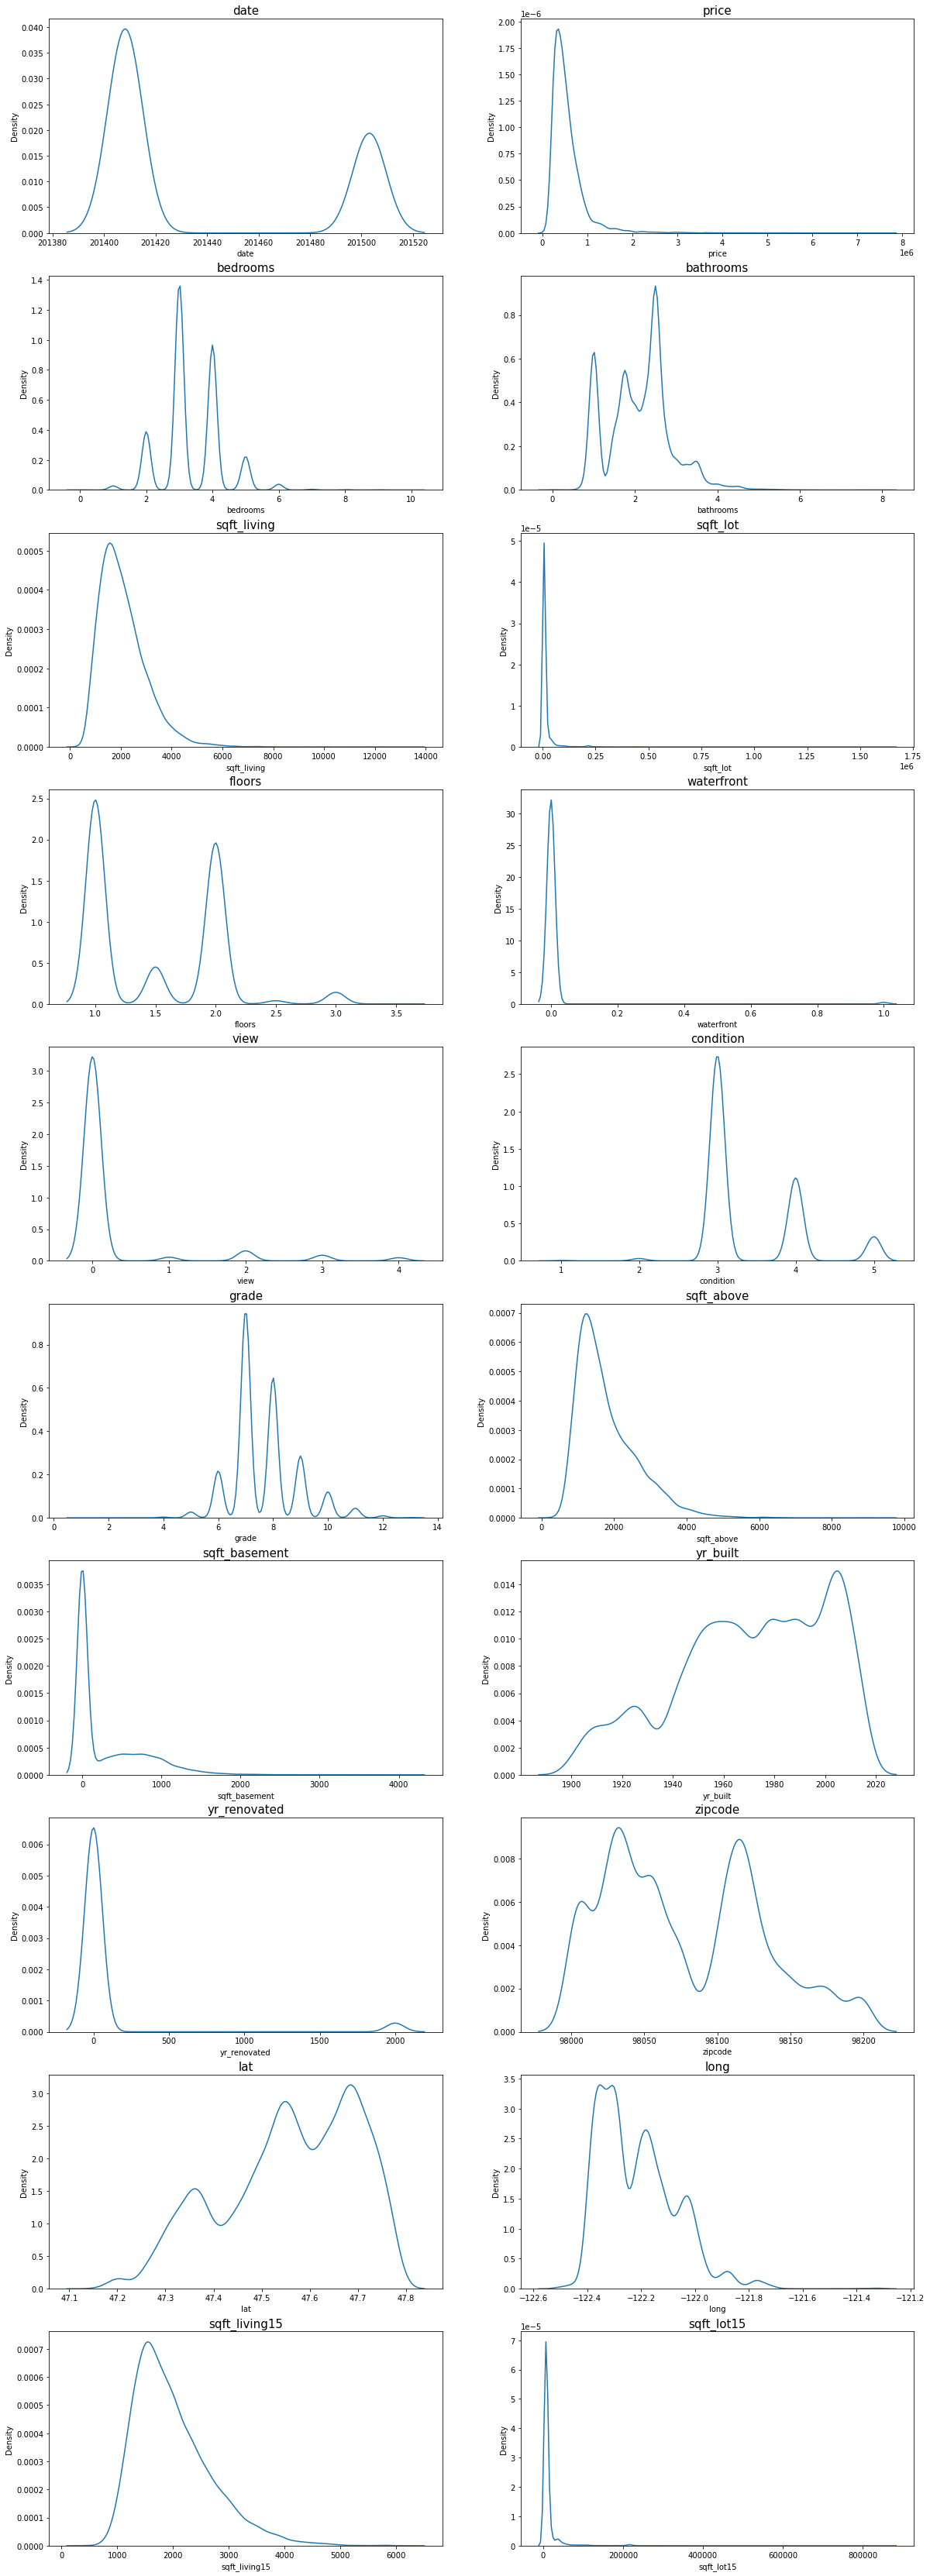

In [7]:
del data['id']
del test['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# visualization
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1

### 목적 값 살펴보기

In [8]:
data['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

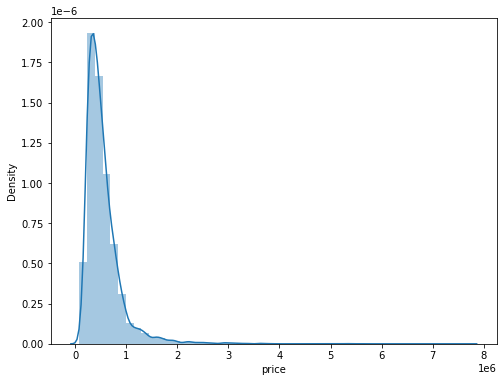

In [9]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['price'])

### 속성 값과 목적 값 사이의 관계 살펴보기

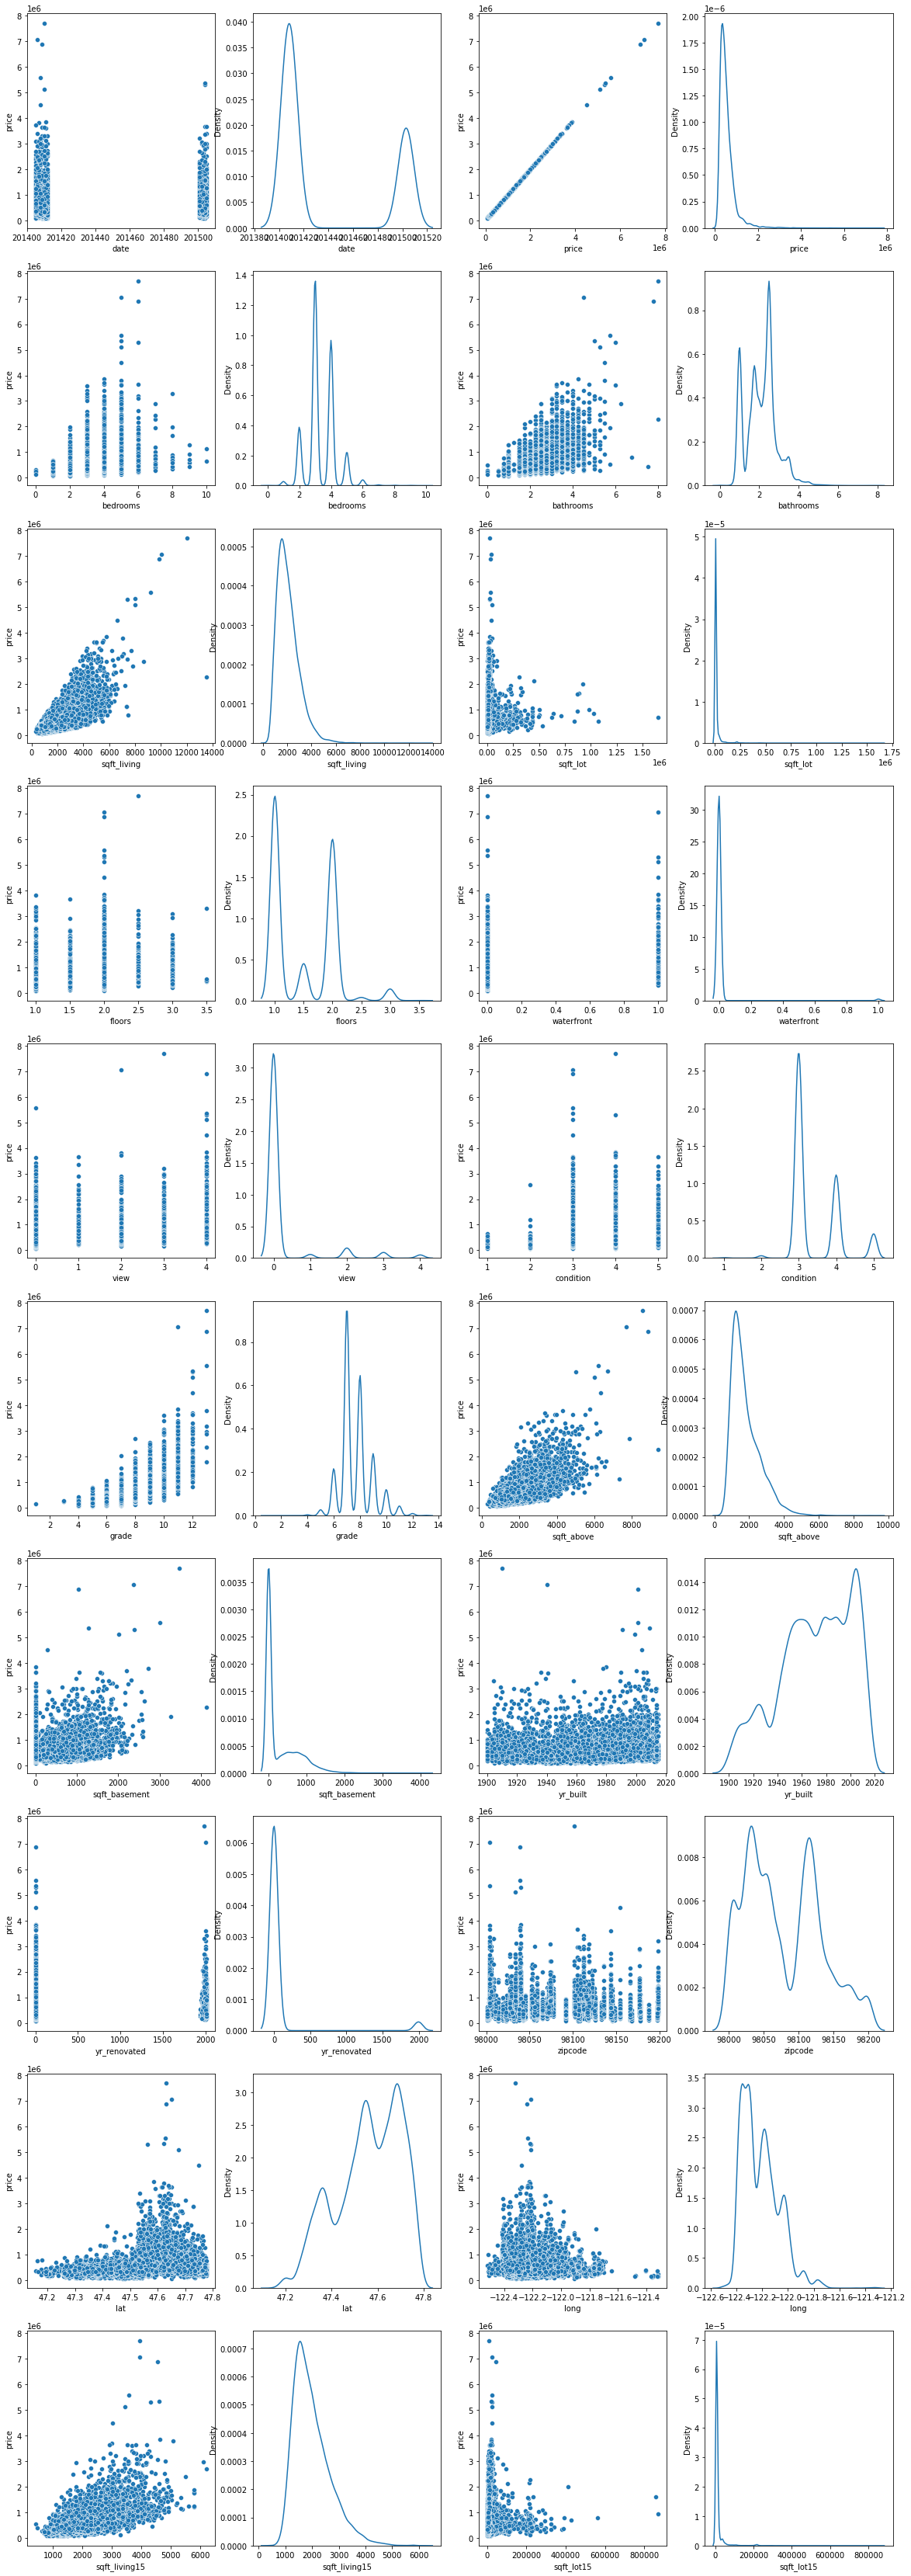

In [10]:
fig, ax = plt.subplots(10, 4, figsize=(20, 60))

# visualization
count = 0
columns = data.columns
for row in range(10):
    for col in range(4):
        if col % 2:
            sns.kdeplot(data[columns[count]], ax=ax[row][col])
            count+=1
        else:
            sns.scatterplot(x=columns[count], y="price", data=data,ax=ax[row][col])

### 목적 값과 선형적으로 가장 관계 있는 속성 알아내기

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

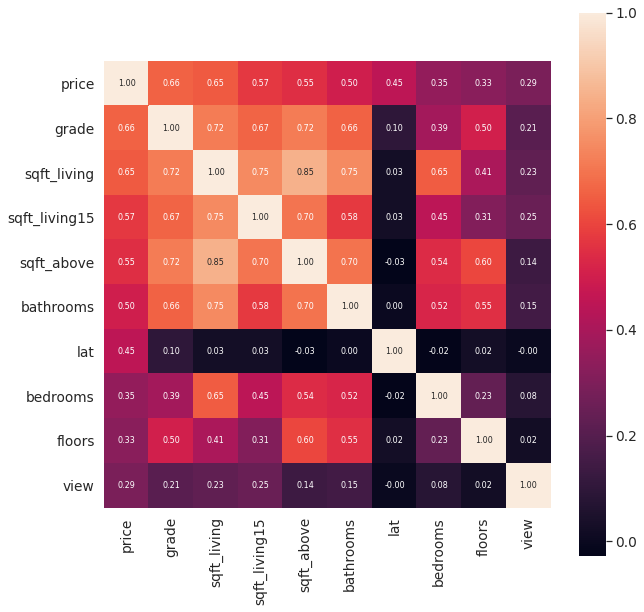

In [11]:
import scipy as sp

cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

## 3. Data preprocessing

### 데이터 분포 고르게 하기

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
# using log
for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    test[c] = np.log1p(test[c].values)    

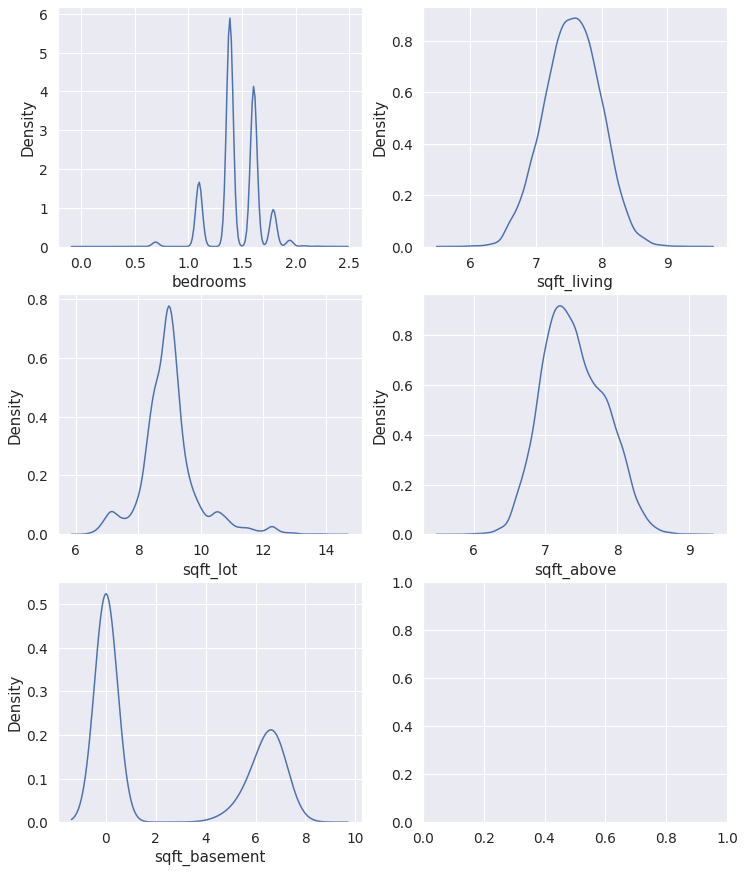

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        #ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### 데이터 형식 맞추기
목적 값도 log를 이용하여 값을 변형 시켜준다.

In [14]:
y = data['price']
y = np.log1p(y)

In [15]:
del data['price']
train = data
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,1830,7200


## 4. Modeling
최종적으로는 앙상블 기법을 사용할 것이고   
앙상블 기법을 사용할 모델은 LGBMRegressor, XGBRegressor이다.   
좋은 모델을 선택하기 위하여 그리드 서치를 이용하여 하이퍼 파라미터를 탐색한다.

### 그리드 서치 함수

In [16]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### 캐글 제출을 위한 함수

In [17]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 그리드 서치를 통한 하이퍼 파라미터 탐색
총 2가지 모델에 대한 하이퍼 파라미터를 탐색하였다.   
주석처리 한 부분은 다른 한 모델에 대한 하이퍼 파라미터로 간결하게 보여주기 위해서   
실행 결과는 생략을 했다.   
탐색한 하이퍼 파라미터 공간은 다음과 같다.   
- LGBMRegressor   
n_estimators : 100, 200, 300, 600, 1000   
max_depth : 10, 20, 25, 30, 60    
learning_rate : 0.1, 0.01, 0.001   
num_leaves : 5, 10, 15, 20   
boosting : 'default', 'goss'   
- XGBRegressor   
n_estimators : 100, 200, 600   
max_depth : 10, 30, 60   
learning_rate : 0.1, 0.01, 0.001   

In [18]:
random_state = 100
param_grid = {
    'n_estimators': [100, 200, 600],
    'max_depth': [10, 30, 60],
    'learning_rate' : [0.1, 0.01, 0.001],
    #'num_leaves' : [5, 10, 15, 20],
    #'num_iterations' : [100, 200, 300],
    #'boosting' : ['goss'],
}

#model = LGBMRegressor(random_state=random_state)
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed: 16.6min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.100,10,200,-0.026858,0.163883
2,0.100,10,600,-0.026949,0.164162
0,0.100,10,100,-0.027048,0.164464
7,0.100,60,200,-0.028487,0.168781
8,0.100,60,600,-0.028487,0.168781
6,0.100,60,100,-0.028530,0.168908
4,0.100,30,200,-0.028589,0.169082
5,0.100,30,600,-0.028589,0.169082
3,0.100,30,100,-0.028639,0.169232
11,0.010,10,600,-0.028868,0.169907


### 각 모델 훈련 및 평가
앙상블 기법에 사용할 모델을 선정하기 위해서   
위에서 그리드 서치를 이용한 것을 참고하되   
최종적으로 캐글의 평가를 이용해서 모델의 성능을 평가했다.   
그리고 여러 하이퍼 파라미터 중에서 좋은 성능을 골라서   
앙상블 기법에 모델의 하이퍼 파라미터로 사용하였다.

In [19]:
#model = LGBMRegressor(boosting='goss', max_depth=60, n_estimators=1000,num_leaves=20,num_iterations=300,
#                      random_state=random_state)
model = XGBRegressor(max_depth=10, n_estimators=200,learning_rate=0.1,
                      random_state=random_state)

save_submission(model, train, y, test, 'xgb', rmsle='0.021')

/home/aiffel-dj28/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.021.csv saved!


### 앙상블 기법
위에서 좋은 모델을 골라서 여러 조합을 이용하여 앙상블 기법을 사용했다.    
최종적으로는 아래의 모델이 목표 점수에 도달하였다.   
즉, 'lgbm 모델 + lgbm 모델('goss') + xgb 모델 + xgb 모델' 이다.

In [20]:
#30 1000 .1 10 300 -> 11234 11073(public)
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)
def avg_save_submission(models, train, y, test, model_name, rmsle=None):
    prediction = AveragingBlending(models, train, y, test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

random_state = 100
models = []
models.append(LGBMRegressor(max_depth=25, n_estimators=600, num_leaves=15,num_iterations=300,
                      random_state=random_state))
#models.append(LGBMRegressor(max_depth=30, n_estimators=1000, num_leaves=15,num_iterations=300,
#                      random_state=random_state))
models.append(LGBMRegressor(boosting='goss', max_depth=60, n_estimators=1000,num_leaves=20,num_iterations=300,
                      random_state=random_state))
models.append(XGBRegressor(max_depth=10, n_estimators=200,learning_rate=0.1,
                      random_state=random_state))
models.append(XGBRegressor(max_depth=10, n_estimators=650,learning_rate=0.1,
                      random_state=random_state))
avg_save_submission(models, train, y, test, 'avg_lgbm', rmsle='0.16')

/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


/home/aiffel-dj28/aiffel/kaggle_kakr_housing/data/submission_avg_lgbm_RMSLE_0.16.csv saved!


## 5. Analysis
최종적으로 목표한 점수에 도달하였다. (Private score 기준 110000 이하)   
/home/aiffel-dj28/Downloads/image.png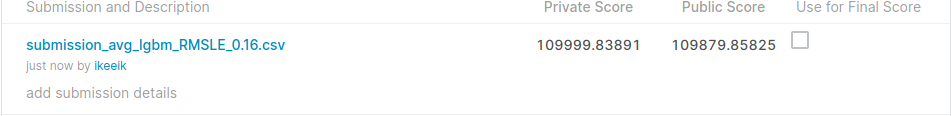

이 프로젝트에서는 간결함을 위해서 시도해서 실패한 것은 모두 제거하고 가장 좋은 것만 기록이 되어 있다.   
그래서 이전에 시도했던 EDA를 통한 feature engineering이나 신경망(딥러닝) 모델을 이용한 방법,    
제시되지 않았지만 다른 모델에 대한 하이퍼 파라미터 탐색 등 여러 시도를 하였다.   
그런 시도를 기록하지 않은 것은 좋은 결과가 아니였고, 임시적으로 한 시도였기 때문에 코드를 병합하기 어렵다는 점이 있었기 때문이다.   

결과적으로 EDA를 통한 feature engineering은 오히려 성능 저하를 일으켰고, 신경망 모델은 데이터가 적어서 그런 지 좋은 성능을 내기 어려웠다. 그래서 EDA를 통한 feature engineering을 빼고 하이퍼 파라미터 탐색과 앙상블 기법에 집중하기로 방향을 정하고 그리드 서치를 이용하여 부스팅 방법을 기반으로 한 모델을 중심으로 좋은 성능을 찾아내고 여러 조합을 통하여 성능을 향상시켜 목표한 점수에 도달하였다.

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?(데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.)
2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?(제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.)
3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?(다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.)

### 평가 항목에 대한 수행
1. 프로젝트의 전 과정을 보면 데이터 전처리, 모델 학습, 예측의 전체 과정을 거쳐 캐글에 submission까지 진행되었다.
2. 'import package', 'EDA','data preprocessing','modeling','analysis' 순으로 전처리, 학습, 최적화 진행 과정이 체계적으로 기술하였다.
3. 마지막 부분에 109999로 private score 기준 110000 이하의 점수를 얻었다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
가장 어려웠던 점은 EDA였다. 속성 값과 목적 값에 상관관계를 고려하여 필요하지 않아 보이는(연관성이 낮은) feature들을 제거 했는데 성능이 오히려 낮아지는 것을 확인할 수 있었다. 그리고 scaling이나 normalization을 해주니까 오히려 성능이 낮아져서 EDA는 포기하고 모델을 만드는 것에 집중을 해야했다. 그리고 하이퍼 파라미터 탐색하는 과정에서 사소한 오타로 인하여 제대로 된 결과를 얻지 못하거나 하이퍼 파라미터 탐색하는 시간이 생각보다 많이 오래 걸려서 힘들었다. 그리고 마지막으로 앙상블 기법에 사용할 모델들을 조합할 때 기준이 모호해서 하나씩 수정하면서 결과를 살펴야 하는 점이 많이 번거로웠다. 
---
- **알아낸 점**    
적절한 하이퍼 파라미터 조정과 앙상블 기법만으로도 성능을 많이 향상시킬 수 있다는 것을 몸소 느낄 수 있었다. 그리고 아무리 사소해 보이는 feature라도 약간의 수정이라도 성능에 영향을 크게 미칠 수 있다는 것을 깨달았다. (scaling이나 normalization을 하나의 feature에만 적용을 해보고 성능이 떨어지는 것을 확인했다.) 그리고 데이터가 충분하지 않으면 신경망을 사용하면 안되는 것을 다시 한 번 느꼈다.

- **모호한 점**    
아직도 EDA를 어떻게 하면 잘 할 수 있을지 어떻게 feature engineering을 해야 할 지 감이 오지 않는다.
---
- **시도한 것들**   
위에서 언급한 여러 EDA 기법과 신경망 모델 사용, 여러 모델에 대한 하이퍼 파라미터 탐색 등이 있다.

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
예전에 공부를 하면서 캐글을 한 적이 있었는데 그 때도 점수에 벽이 있는 것처럼 넘기 힘들다는 것을 느꼈는데 이번 프로젝트하면서도 느꼈다. 우선 처음에는 EDA를 열심히 했는데 모두 다 실패를 한다는 것을 깨닫고 눈물을 훔치면서 포기할 수 밖에 없었다. 사실 이번 프로젝트하면서 가장 오랜 시간이 걸렸는데 모두 다 버렸다.ㅠㅠ 그리고 처음에 시도한 것은 그냥 하나의 부스팅 모델로 점수를 넘길려고 했다. 하지만 나의 쓸데 없는 시도만 늘어가고 어느 점수 선에 수렴되는 것을 느꼈다. 아마 EDA 없이 그냥 좋은 모델 하나로 통과시키지 못하는 점수를 제시한 것 같다. 그래서 다시 EDA로 돌아가기에는 너무나 두려운 나머지 내가 선택할 수 있는 방법은 하나 뿐이였다. 바로 앙상블 기법을 이용해서 점수를 도달하는 것이였다. 하지만 앙상블을 사용한다고 바로 극적인 변화가 있진 않았다. 약간의 향상은 있었지만 점수에 도달하기에 조금 부족해서 앙상블 기법에 사용하는 모델을 하나씩 늘려가기 시작했다. 하지만 어느 순간 다시 점수가 떨어지는 것을 보고 역시 EDA가 필수적인가 생각을 하면서 포기하려는 순간에 지금까지 노력한 시간이 아까워서 랜덤 시드를 바꿔보기 시작했고 그 약간의 부족함이 매워지기 시작했다. 만족할 만한 랜덤 시드를 찾은 뒤에는 진짜 세밀하게 앙상블 기법에 사용한 하이퍼 파라미터를 하나만 골라서 조금씩 변경하는 것으로 점수를 넘을 수 있었다.   
다시 되돌아 보면 시도한 EDA를 다 실패해서 멘탈이 나가서 코딩도 잘 안되는 상황에서 하이퍼 파라미터 찾는 노가다 과정과 조금이라도 성능을 높이는 조합을 찾는 앙상블을 위한 노가다로 해결한 것 같다. 다음에는 EDA에 대해서도 잘 활용할 수 있게 되어서 더 좋은 결과를 얻을 수 있도록 공부를 해야 할 것 같다.